## Hyperparameter Tuning in SageMaker

In [50]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cifar"

role = sagemaker.get_execution_role()

In [3]:
from torchvision.datasets import CIFAR10
from torchvision import transforms


local_dir = 'data'
CIFAR10.mirrors = ["https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/CIFAR10/"]
CIFAR10(
    local_dir,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
# TODO: Upload the data to an S3 bucket. You can use the sagemaker_session object, boto3 or the AWS CLI
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix=prefix)

print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-755391689112/sagemaker/DEMO-pytorch-cifar


In [10]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="scripts/cifar.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

In [11]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [12]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [13]:
tuner =  HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [15]:
tuner.fit({"training": inputs}, wait=True)

.......................................................................................................................................................!


In [16]:
tuner.best_estimator()
tuner.best_estimator().hyperparameters()


2021-12-20 23:54:00 Starting - Preparing the instances for training
2021-12-20 23:54:00 Downloading - Downloading input data
2021-12-20 23:54:00 Training - Training image download completed. Training in progress.
2021-12-20 23:54:00 Uploading - Uploading generated training model
2021-12-20 23:54:00 Completed - Training job completed

2021-12-20 23:54:00 Starting - Preparing the instances for training
2021-12-20 23:54:00 Downloading - Downloading input data
2021-12-20 23:54:00 Training - Training image download completed. Training in progress.
2021-12-20 23:54:00 Uploading - Uploading generated training model
2021-12-20 23:54:00 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.08367322979687022',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-20-23-42-04-368"',
 'sagemaker_program': '"cifar.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-755391689112/pytorch-training-2021-12-20-23-42-04-368/source/sourcedir.tar.gz"'}

In [17]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.t2.medium")


2021-12-20 23:54:00 Starting - Preparing the instances for training
2021-12-20 23:54:00 Downloading - Downloading input data
2021-12-20 23:54:00 Training - Training image download completed. Training in progress.
2021-12-20 23:54:00 Uploading - Uploading generated training model
2021-12-20 23:54:00 Completed - Training job completed
-------------------------!

In [76]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(
    model_data='s3://sagemaker-us-east-1-755391689112/pytorch-training-2021-12-20-23-55-15-841/model.tar.gz',
    role=role, 
    entry_point='scripts/cifar.py',
    py_version='py36',
    framework_version="1.8",
)
predictor = pytorch_model.deploy(instance_type='ml.t2.medium', initial_instance_count=1)

--------!

## Query the Endpoint

In [96]:
import gzip 
import numpy as np
import random
import os
import torch

file = 'data/cifar-10-batches-py/data_batch_3'
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data=unpickle(file)
data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [97]:
img=np.reshape(data[b'data'][2], (1, 3, 32, 32))

In [98]:
type(img)
img.shape

(1, 3, 32, 32)

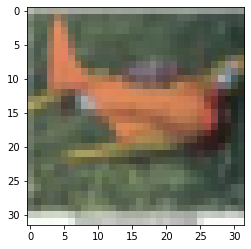

In [99]:
row=data[b'data'][2]
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

import matplotlib.pyplot as plt
plt.imshow(test_image);



In [100]:
response = predictor.predict(img) # TODO: Query the endpoint
print(response)

[[   0.         -148.67037964 -339.80426025 -400.50708008 -426.68807983
  -560.08868408 -644.45300293 -440.7796936  -192.56289673 -201.6519928 ]]


### Cleanup

After you have finished with this exercise, remember to delete the prediction endpoint to release the instance associated with it